In this notebook I will explore setting up a [Siamese Neural Network](http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf) (SNN), using the fastai/pytorch framework, to try and identify whales by their flukes (tail fins). The dataset comes from the kaggle humpback whale identification [challege](https://www.kaggle.com/c/humpback-whale-identification). The inspiriation for this technique originated from Martin Piotte's [kaggle kernel](https://www.kaggle.com/martinpiotte/whale-recognition-model-with-score-0-78563) which implemented a SNN in keras.

I'll be focusing on training an SNN as they are specifically tailored for one-shot learning tasks, which consists of classification under the restriction that we may only observe a single example of each possible class before making a prediction about a test instance. This is extremely useful given that in my previous [post](http://afitts.github.io/2018/11/04/humpback/) I found that the majority of whales in the dataset only have 1-4 examples in the training set. 

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [2]:
import fastai
fastai.__version__

'1.0.39'

In [3]:
path = Path('../input')
train = pd.read_csv(path/'train.csv'); 

In [4]:
## Filtering classes with at least 60 images for quick experiments
cnter = Counter(train.Id.values)
train['cnt']=train['Id'].apply(lambda x: cnter[x])
#Not consider new_whale images and hence considering 500 as upper cutoff
train = train[(train['cnt']>60) & (train['cnt']<500)] 

Duplicating the entire dataframe so that we can generate a positive pair and a negative pair for each image; maintaing 50% positive pairs and 50% negative pairs for the saimese network. 
Why this is done can be understood in below sections

In [5]:
train['target'] = 1
train1 = train.copy()
train1['target'] = 0
train = train.append(train1)
target_col = 3

## Custom Itembase and ItemList for Siamese Networks
* Much of this follows the Custom Item List tutorial(https://docs.fast.ai/tutorial.itemlist.html#Example:-ImageTuple)
* Though blindly following the steps in the tutorial might work, i was not very comfortable doing that and hence spent a few hours digging into the library  and understanding how various pieces inside it work
* I would suggest starting with tabular data.py as tabular is relatively easier to follow and gives an overall idea of the different pieces involved in getting the databunch ready
* At a very high level, creation of databunch for Image application follows this path. 
    *  When factory methods like from_df are called, it instantiates the corresponding ImageItemList. Important things includes creation of items, xtra df with necessary info etc. (vision/data.py - ImageItemList class)
    * Most imp thing to note here is the get() func responsible for retreving data given the index. This func links the ImageItemList to the Image(Itembase) by returning the retrived item as the class of Itembase. I missed this as it was very subtle in the code and couldnt connect the dots initially.
    * .split_by_.. - Much of this happens in data_block.py, ItemLists class and easier to follow
    * Label_from_df - This is where a lot of heavy lifting seems to happen. As ItemLists doesnt have label_from_df attri, it falls back to ItemList class(using '____get__attr__') and does the job. Also, finally the class is changed to LabelLists which gives it the functionality to create databunch etc. Refer to data_block.py and LabelList and LabelLists classes
    * Also Deduction of target variable class, and assignment of processor, loss_func etc happen here
    * .databunch does the rest

In [6]:
mean, std = torch.tensor(imagenet_stats)

In [7]:
# The primary difference from the tutorial is with how normalization is being done here
class SiamImage(ItemBase):
    def __init__(self, img1, img2): ## These should of Image type
        self.img1, self.img2 = img1, img2
        self.obj, self.data = (img1, img2), [(img1.data-mean[...,None,None])/std[...,None,None], (img2.data-mean[...,None,None])/std[...,None,None]]
    def apply_tfms(self, tfms,*args, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms, *args, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, *args, **kwargs)
        self.data = [(self.img1.data-mean[...,None,None])/std[...,None,None], (self.img2.data-mean[...,None,None])/std[...,None,None]]
        return self
    def __repr__(self): return f'{self.__class__.__name__} {self.img1.shape, self.img2.shape}'
    def to_one(self):
        return Image(mean[...,None,None]+torch.cat(self.data,2)*std[...,None,None])

We define get() func such that we get similar pair of images and different pair of images based on idx value. Similar for first half index values and different for next half. Hence the duplicity in dataframe initially.
Currently did things dumbly just to demostrate. Can do generation of pairs, dealing with underbalanced classes and many other things in a much better way 

In [8]:
class SiamImageItemList(ImageItemList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
#         self._label_cls=FloatList
    
    def __len__(self)->int: return len(self.items) or 1 
    
    def get(self, i):
        match=1
        if i>=len(self.items)//2:#"First set of iteration will generate similar pairs, next will generate different pairs"
            match = 0
        fn = self.items[i]
        img1 = super().get(i) # Returns Image class object
        
        imgs = self.xtra.Image.values
        ids = self.xtra.Id.values
        wcls = ids[i]
        simgs = imgs[ids == wcls]
        dimgs = imgs[ids != wcls]
        if len(simgs)==1 and match==1:
            fn2=fn
        else:
            while True:
                np.random.shuffle(simgs)
                np.random.shuffle(dimgs)
                if simgs[0] != fn:
                    fn2 = [simgs[0] if match==1 else dimgs[0]][0]
                    break
            fn2 = self.items[np.where(imgs==fn2)[0][0]]
        img2 = super().open(fn2) # Returns Image class object
        return SiamImage(img1, img2)
    
    def reconstruct(self, t): return SiamImage(mean[...,None,None]+t[0]*std[...,None,None], mean[...,None,None]+t[1]*std[...,None,None])
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(9,10), **kwargs):
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

In [9]:
whl_tfms = get_transforms()
bs = 8

In [10]:
data = (SiamImageItemList.from_df(df=train, path=path/'train', cols=0)
         .random_split_by_pct(valid_pct=0.2, seed=34)
         .label_from_df(cols=target_col, label_cls=FloatList)
         .transform(whl_tfms, size=224)
         .databunch(bs=bs))

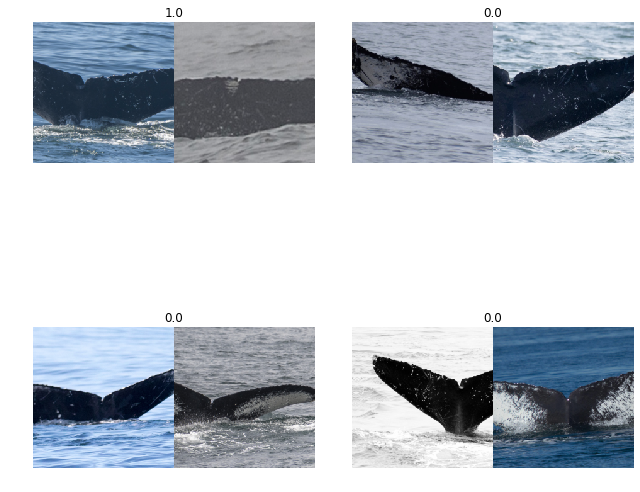

In [11]:
data.show_batch(2)

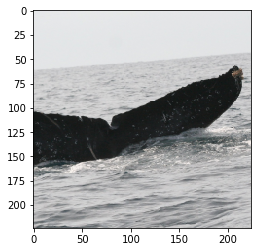

In [12]:
# Checking if the normalization done above is correct
x = next(iter(data.train_dl))
t=x[0][0][0].cpu()
to = mean[...,None,None] + t* std[...,None,None]
import torchvision
ti = torchvision.transforms.ToPILImage(to)
plt.imshow(to.numpy().transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


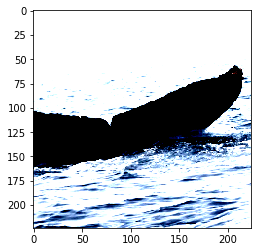

In [13]:
plt.imshow(t.numpy().transpose(1,2,0))

## Siamese Network

In [14]:
from fastai.vision import learner

class SiameseNet(nn.Module):
    def __init__(self, arch=models.resnet18, lin_ftrs=[256, 128], emb_sz=128,ps=0.5, bn_final=False):
        super(SiameseNet, self).__init__()
        self.arch, self.emb_sz = arch, emb_sz
        self.lin_ftrs, self.ps, self.bn_final = lin_ftrs, ps, bn_final
        self.body = learner.create_body(self.arch, True, learner.cnn_config(self.arch)['cut'])
        self.head = learner.create_head(num_features_model(self.body) * 2, self.emb_sz, self.lin_ftrs, self.ps,self.bn_final)
        self.cnn = nn.Sequential(self.body, self.head)
                                  
    def forward(self, x1, x2):
        output1 = self.cnn(x1)
        output2 = self.cnn(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.cnn(x)

**Loss function**

After comparing several loss functions and I've found that contrastive loss works the best in the current setup. Distance based logistic loss gives similar performance when model is trained with singe precision, but worse results for training with half precision.

In [15]:
class ContrastiveLoss(nn.Module):
    """Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """
    def __init__(self, margin=5.):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, ops, target, size_average=True):
        op1, op2 = ops[0], ops[1]
        dist = F.pairwise_distance(op1, op2)
        pdist = dist*target
        ndist = dist*(1-target)
        loss = 0.5* ((pdist**2) + (F.relu(self.margin-ndist)**2))
        return loss.mean() if size_average else losses.sum()

In [16]:
model = SiameseNet().cuda()
apply_init(model.head, nn.init.kaiming_normal_)
loss_func=ContrastiveLoss().cuda()
siam_learner = Learner(data, model, loss_func=loss_func, model_dir=Path(os.getcwd()))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


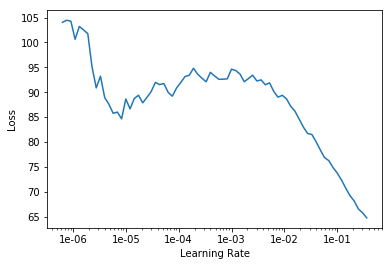

In [17]:
siam_learner.lr_find()
siam_learner.recorder.plot()

In [18]:
siam_learner.fit_one_cycle(5, slice(3*1e-2))

epoch,train_loss,valid_loss
1,47.814510,171.353699
2,20.523115,10.899207
3,13.116446,10.829012
4,10.895652,11.075461
5,9.889898,11.046269


## Extract Embedding

In [ ]:
def extract_embedding(dl, ds, mdl):
    mdl.eval()
    with torch.no_grad():
        preds = torch.zeros((len(ds), 128))
        start=0
        for cnt, (x, y) in enumerate(dl, start=0):
            size = x[0].shape[0]
            preds[start:start+size,:] = model.get_embedding(x[0])
            start+= size
        return preds

In [ ]:
data = (SiamImageItemList.from_df(df=trn_imgs, path=path/'train', cols=0)
         .random_split_by_pct(valid_pct=1, seed=34)
         .label_from_df(cols=target_col, label_cls=FloatList)
         .transform(whl_tfms, size=224)
         .databunch(bs=4))

In [ ]:
dl = data.valid_dl
ds = data.valid_ds
res = extract_embedding(dl, ds, model)
whlc=np.array([trn_imgs.loc[trn_imgs.Image == Path(i).name, 'Id'].values[0] for i in ds.items])

Embedding Visualization

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [ ]:
pca.fit(res)
embs2d = pca.transform(res)

In [ ]:
import colorsys
def random_colors(N, bright=True):
    # This code is borrowed from https://github.com/matterport/Mask_RCNN
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def plot_embeddings(embeddings=None,whlc=None, xlim=None, ylim=None):
# This code is borrowed from https://github.com/adambielski/siamese-triplet/blob/master/Experiments_MNIST.ipynb
    plt.figure(figsize=(10,10))
    for cnt, i in enumerate(set(whlc)):
#         print(cnt, i)
        inds = np.where(whlc==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[cnt])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(set(whlc))

Not expecting something pretty good, given everything done here is pretty basic and crude. Lets see!!

In [ ]:
colors = random_colors(len(set(whlc)))
plot_embeddings(embs2d,whlc, xlim=None, ylim=None)